## Titanic Competition Tutorial

In [996]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

scaler = StandardScaler()

In [997]:
def fit_cabin(row, data):
    if pd.isnull(row["Cabin"])==False:
        return row["Cabin"][0]
    
    mode_this_class = data[data["Pclass"]==row["Pclass"]]["Cabin"].mode()
    if mode_this_class.empty:
        return "U"
    else:
        return mode_this_class[0][0]


In [998]:
def group_cabins(row):
    if(pd.isnull(row)):
        return "U"
    else:
        return row[0]

In [999]:
def prepare_before_predictions(data:pd.DataFrame):
    X = data[[n for n in data.columns if n!= "Survived" and n not in  ["Name", "Cabin", "Ticket",  "Embarked", "PassengerId"]]]
    X = pd.get_dummies(X[[n for n in X.columns if n!="Cabin_PRED"]])
    return X

In [1000]:
def pre_process_data(data:pd.DataFrame):
    Y = data["Survived"]
    X = data[[n for n in data.columns if n!= "Survived" and n not in  ["Name", "Cabin","Ticket",  "Embarked", "PassengerId"]]]
    
    X = pd.get_dummies(X[[n for n in X.columns if n!="Cabin_PRED"]])

    # train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.6, random_state=42)
    
    # growing-test split
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.4, random_state=42)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [1001]:
def build_tree(X_train, Y_train):

    param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']
    }
    tree = DecisionTreeClassifier(random_state=42)

    grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', verbose=1)
    grid_search.fit(X_train, Y_train)
    best_tree = grid_search.best_estimator_


    best_tree.fit(X_train, Y_train)
    return best_tree

In [1002]:
train_data = pd.read_csv(fr"data\train.csv")
test_data = pd.read_csv(fr"data\test.csv")

In [1003]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [1004]:
# train_data['CabinKnown'] = train_data['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)
# test_data['CabinKnown'] = test_data['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)

# print(train_data[['CabinKnown', 'Survived']].groupby('CabinKnown').mean())

In [1005]:
train_data["Cabin_PRED"] = train_data.apply(lambda row: fit_cabin(row, train_data), axis = 1)
test_data["Cabin_PRED"] = test_data.apply(lambda row: fit_cabin(row, test_data), axis = 1)
# train_data["Cabin_PRED"].fillna("U", inplace=True)
# train_data["Cabin_PRED"].fillna("U", inplace=True)

train_data.groupby("Pclass")["Cabin_PRED"].unique()

Pclass
1    [C, E, A, B, D, T]
2             [D, F, E]
3             [G, F, E]
Name: Cabin_PRED, dtype: object

In [1006]:
train_data.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Cabin_PRED       0
dtype: int64

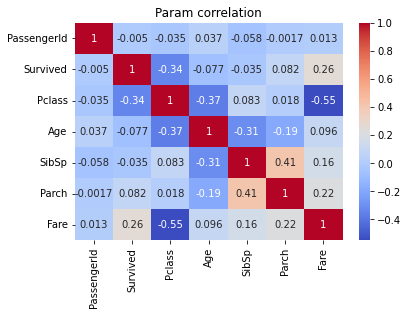

In [1007]:

correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Param correlation")
plt.show()

In [1008]:
# train_data["Cabin_GROUPED"] = train_data["Cabin"].apply(group_cabins)
# test_data["Cabin_GROUPED"] = test_data["Cabin"].apply(group_cabins)

In [1009]:
train_data["FamilySize"] = train_data["SibSp"]+train_data["Parch"]+1
test_data["FamilySize"] = test_data["SibSp"]+test_data["Parch"]+1

In [1010]:
train_data["Age"] = train_data["Age"].apply(lambda x: train_data["Age"].median() if pd.isna(x) else x)
test_data["Age"]= test_data["Age"].apply(lambda x: test_data["Age"].median() if pd.isna(x) else x)

In [1011]:
train_data[['Age', 'Fare']] = scaler.fit_transform(train_data[['Age', 'Fare']])
test_data[['Age', 'Fare']] = scaler.fit_transform(test_data[['Age', 'Fare']])


<Figure size 864x432 with 0 Axes>

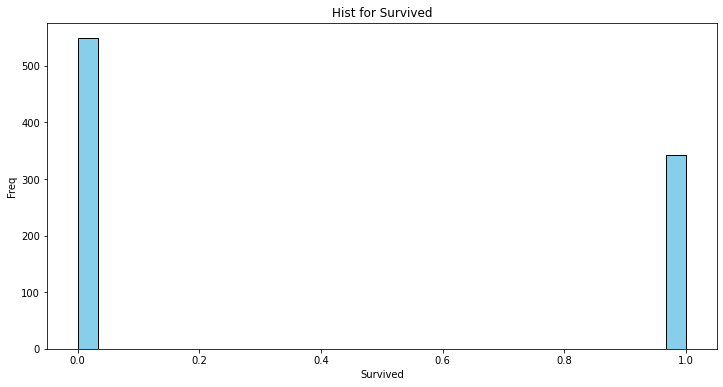

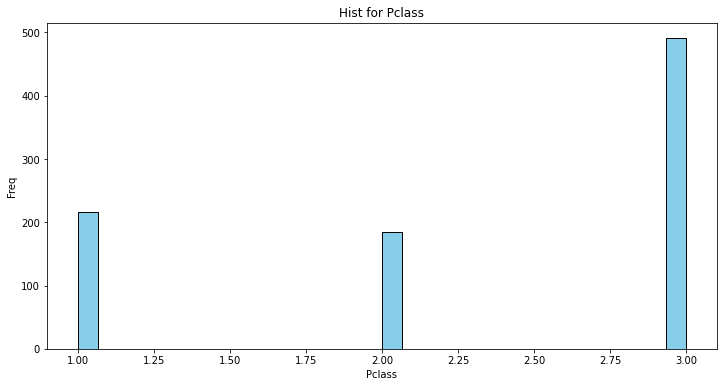

<Figure size 864x432 with 0 Axes>

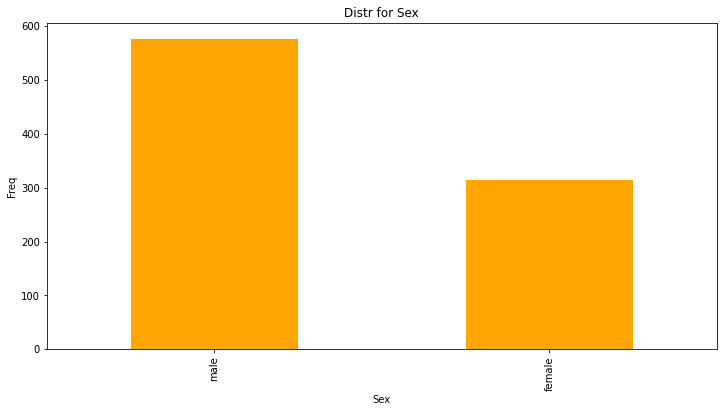

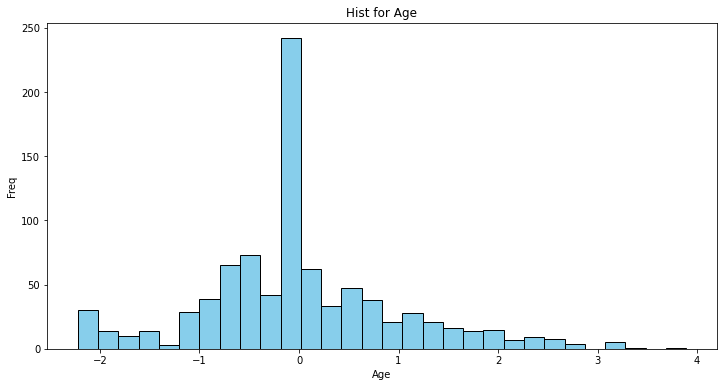

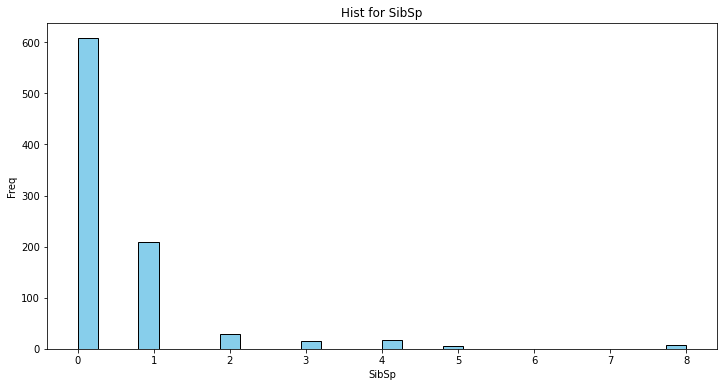

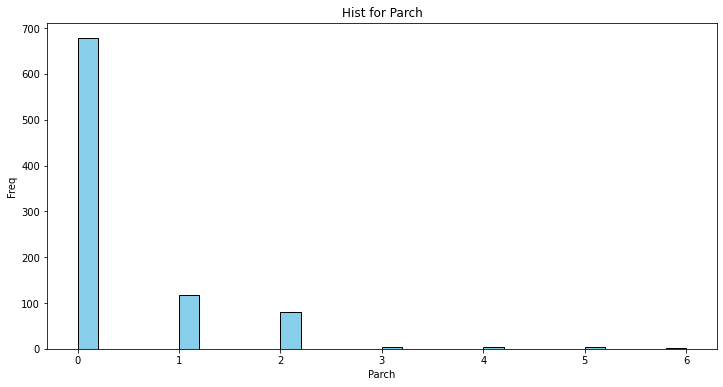

<Figure size 864x432 with 0 Axes>

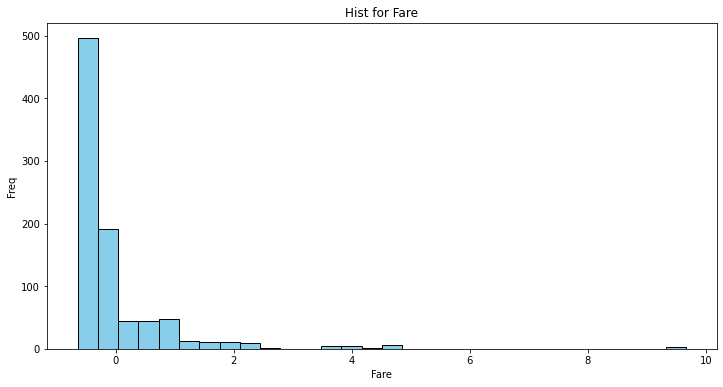

<Figure size 864x432 with 0 Axes>

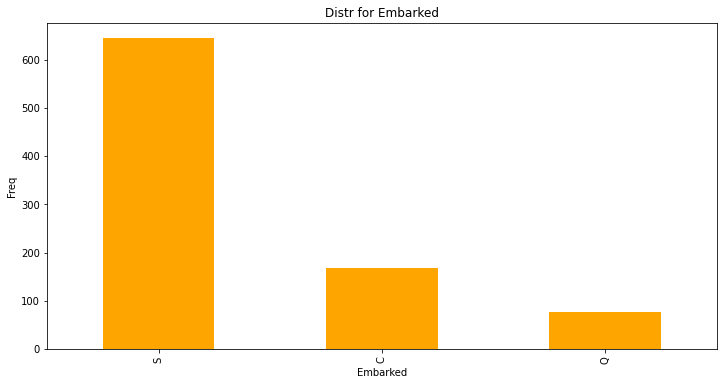

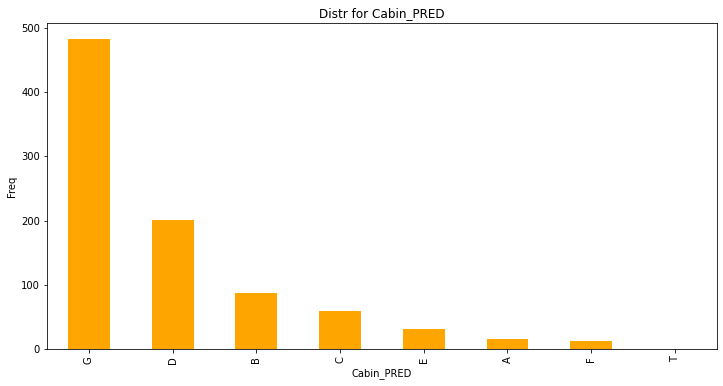

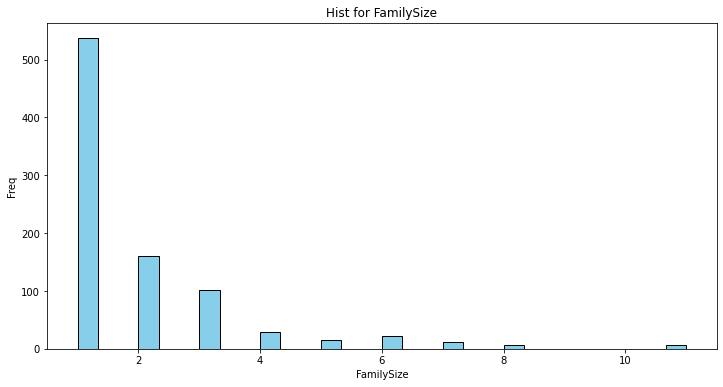

In [1012]:
for n in train_data.columns:
    plt.figure(figsize = [12,6])
    if n == "Name" or n == "Ticket" or n == "Cabin" or n == "PassengerId":
        continue
    if train_data[n].dtype in ['int64', 'float64']:
        plt.hist(train_data[n], bins=30, color='skyblue', edgecolor='black')
        plt.title(f"Hist for {n}")
        plt.xlabel(n)
        plt.ylabel("Freq")
    else:
        train_data[n].value_counts().plot(kind='bar', color='orange')
        plt.title(f"Distr for {n}")
        plt.xlabel(n)
        plt.ylabel("Freq")      

    plt.show()

In [1013]:
train_data.head()

women = train_data[train_data["Sex"]=="female"]["Survived"]
rate_women = sum(women)/len(women)
print(f"Percent of women survived: {rate_women}")

men = train_data[train_data["Sex"]=="male"]["Survived"]
rate_men = sum(men)/len(men)
print(fr"Percent of men survived: {rate_men}")

Percent of women survived: 0.7420382165605095
Percent of men survived: 0.18890814558058924


In [1014]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = pre_process_data(train_data)

In [1015]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_PRED,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,-0.565736,1,0,A/5 21171,-0.502445,NaN,S,G,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.663861,1,0,PC 17599,0.786845,C85,C,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,-0.258337,0,0,STON/O2. 3101282,-0.488854,NaN,S,G,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.433312,1,0,113803,0.420730,C123,S,C,2
4,5,0,3,"Allen, Mr. William Henry",male,0.433312,0,0,373450,-0.486337,NaN,S,G,1


Fitting 5 folds for each of 72 candidates, totalling 360 fits


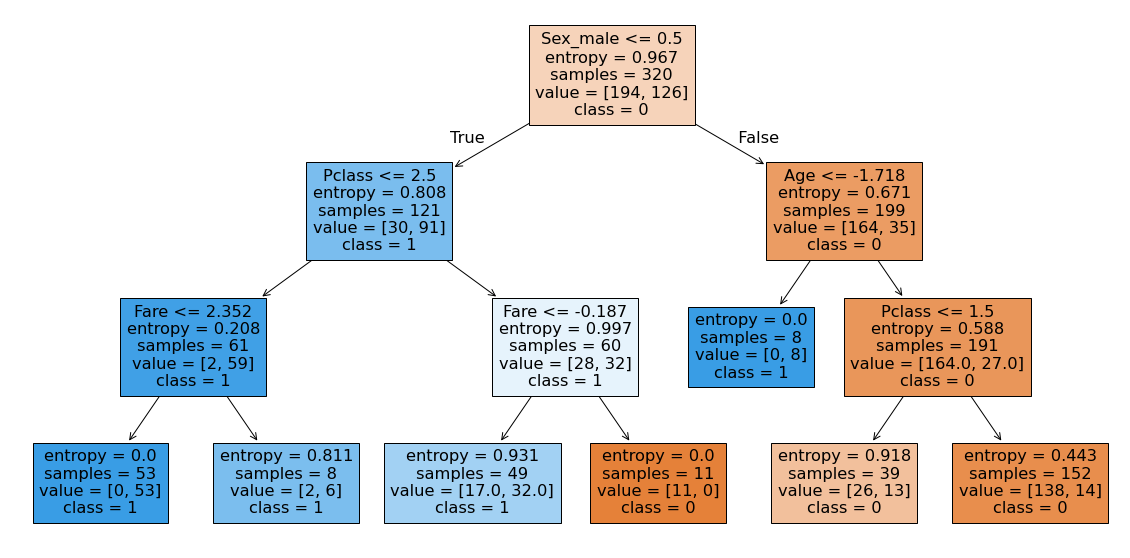

In [1016]:
tree = build_tree(X_train, Y_train)
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X_train.columns, class_names=['0', '1'], filled=True)
plt.show()

In [1017]:
predictions = tree.predict(X_val)

accuracy_score_metric = accuracy_score(Y_val, predictions)
print(fr"Accuracy Score: {accuracy_score_metric}")


Accuracy Score: 0.7850467289719626


In [1018]:
from sklearn.model_selection import cross_val_score


predictions = tree.predict(X_test)

accuracy_score_metric = accuracy_score(Y_test, predictions)
print(fr"Accuracy Score: {accuracy_score_metric}")

scores = cross_val_score(tree, X_train, Y_train, cv=5, scoring='accuracy')
print("Cross Validation:", scores.mean())

Accuracy Score: 0.7983193277310925
Cross Validation: 0.840625


In [1019]:
forest_model=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
forest_model.fit(X_train, Y_train)
predictions = forest_model.predict(X_val)
accuracy_score_metric = accuracy_score(Y_val, predictions)
print(fr"Accuracy Score: {accuracy_score_metric}")



Accuracy Score: 0.8037383177570093


In [1020]:

predictions = forest_model.predict(X_test)

accuracy_score_metric = accuracy_score(Y_test, predictions)
print(fr"Accuracy Score: {accuracy_score_metric}")

scores = cross_val_score(forest_model, X_train, Y_train, cv=5, scoring='accuracy')
print("Cross Validation:", scores.mean())

Accuracy Score: 0.8151260504201681
Cross Validation: 0.853125


In [1024]:
predictions = forest_model.predict(prepare_before_predictions(test_data))

In [1026]:
output = pd.DataFrame({"PassengerId":test_data["PassengerId"],"Sex":test_data["Sex"], "Survived":predictions})

print(output.groupby("Sex")["Survived"].mean())


Sex
female    0.914474
male      0.033835
Name: Survived, dtype: float64


In [1023]:
output[["PassengerId", "Survived"]].to_csv("submission.csv", index = False)